## Прогнозирование группы пользователей для осуществления таргетированной рекламы банковского продукта

### Описание проекта
Задача банка предложить потребительский кредит и при этом максимизировать [показатель конверсии](https://www.unisender.com/ru/support/about/glossary/chto-takoe-cr-conversion-rate/), который равен отношению количества пользователей, принявших кредит, к общему количеству пользователей, которым поступили предложения *(precision)*. Решение этой задачи актуально для банка, потому что это позволит сократить расходы на персональный маркетинг, но при этом достичь максимальной выгоды. Данный проект оптимизирует выбор кандидатов для персонального предложения о предоставлении кредита. В процесс отбора кандидатов можно внерить алгоритм отсева поенциальных кандидатов, готовых взять кредит. 
### Постановка бизнес и математической задачи
Предположительно, нам известно сколько было затрачено времени и средств на проведение прошлогодней кампании. Для измерения бизнес цели мы планируем использовать сравнение затраченных и полученных средств текущей и прошлогодней кампании. Критерий успеха — доход, превышающий доход прошлогодней кампании (или превышение предсказанных показателей дохода, тк может быть тренд увеличения прибыли).

С математической точки зрения мы хотим, чтобы как можно больше людей из тех, кого мы выберем приняли наше предложение. Нам требуется построить бинарный классификатор, с вероятностными прогнозами. Для повышения показателя конверсии нам необходимо оптимизировать precision, но так же необходимо охватить больше потенциально согласных пользователей, поэтому мы будем оптимизировать __F1 score__ и следить за __precision__.
### Постановка бизнес и математической задачи
Предположительно, нам известно сколько было затрачено времени и средств на проведение прошлогодней кампании. Для измерения бизнес цели мы планируем использовать сравнение затраченных и полученных средств текущей и прошлогодней кампании. Критерий успеха — доход, превышающий доход прошлогодней кампании (или превышение предсказанных показателей дохода, тк может быть тренд увеличения прибыли).

С математической точки зрения мы хотим, чтобы как можно больше людей из тех, кого мы выберем приняли наше предложение. Нам требуется построить бинарный классификатор, с вероятностными прогнозами. Для повышения показателя конверсии нам необходимо оптимизировать precision, но так же необходимо охватить больше потенциально согласных пользователей, поэтому мы будем оптимизировать F1 score и следить за precision.

In [36]:
!pip install graphviz

In [37]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

In [38]:
file_name = "BPL.csv"
df = pd.read_csv(file_name)
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


## Описание колонок
* **ID** : ID пользователя

* **Age** : Число полных лет пользователя

* **Experience** : Стаж работы

* **Income** : Средний месячный доход в тысячах долларов

* **ZIP Code** : Почтовый индекс

* **Family** : Размер семьи

* **CCAvg** : Средняя трата по кредитной карте за месяц

* **Education** : Степень образования.
   0. Среднее  
   1. Высшее  
   2. Доктор наук  
   

* **Mortgage** : Стоимость ипотеки при наличии. (в тысячах долларов)

* **Personal Loan** : Принял ли клиент предожение в прошлогодней кампании

* **Securities Account** : Есть ли у клиента счет в банке с ценными бумагами(брокерский счет)

* **CD Account** : Есть ли у клиента банковский вклад

* **Online** : Пользуется ли клиент услугами интернет - банкинга?

* **Credit card** : Использует ли клиент кредитную карту, выпущенную банком

# EDA

In [39]:
# there are no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [40]:
# numeric and categorical features
num_cols = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
intersection_cols = ['Education', 'Family']
cat_cols = list((set(df.columns) - set(num_cols)).union(set(intersection_cols)))

print('Numeric Columns:', num_cols)
print('Categorical Columns:', cat_cols)
print('Intersection Columns:', intersection_cols)

Numeric Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education', 'ZIP Code']
Categorical Columns: ['CreditCard', 'Education', 'Personal Loan', 'ID', 'Securities Account', 'Online', 'CD Account', 'Family']
Intersection Columns: ['Education', 'Family']


In [41]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [42]:
df.describe().loc['min']

ID                       1.0
Age                     23.0
Experience              -3.0
Income                   8.0
ZIP Code              9307.0
Family                   1.0
CCAvg                    0.0
Education                1.0
Mortgage                 0.0
Personal Loan            0.0
Securities Account       0.0
CD Account               0.0
Online                   0.0
CreditCard               0.0
Name: min, dtype: float64

In [43]:
df['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

Мы имеем дело с бинарной классификацией по сильно несбалансированной выборке(9:1)  
Рассмотрим корреляцию признаков

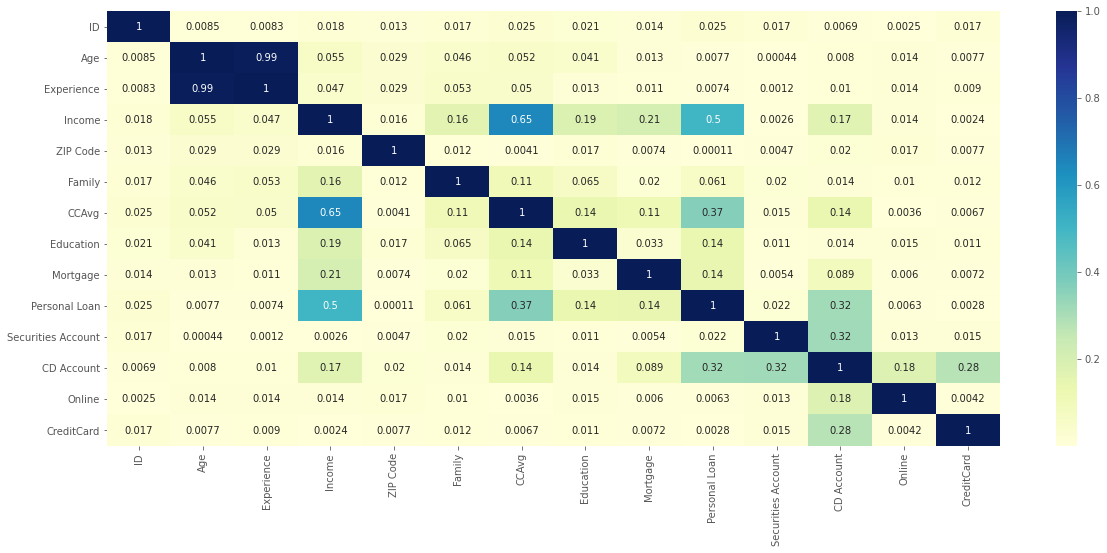

In [44]:
plt.figure(figsize=(20,8))
sns.heatmap(abs(df.corr()), annot=True, fmt='.2g',cmap='YlGnBu')
plt.show()

Видно, что **Experience** и **Age** коррелируют

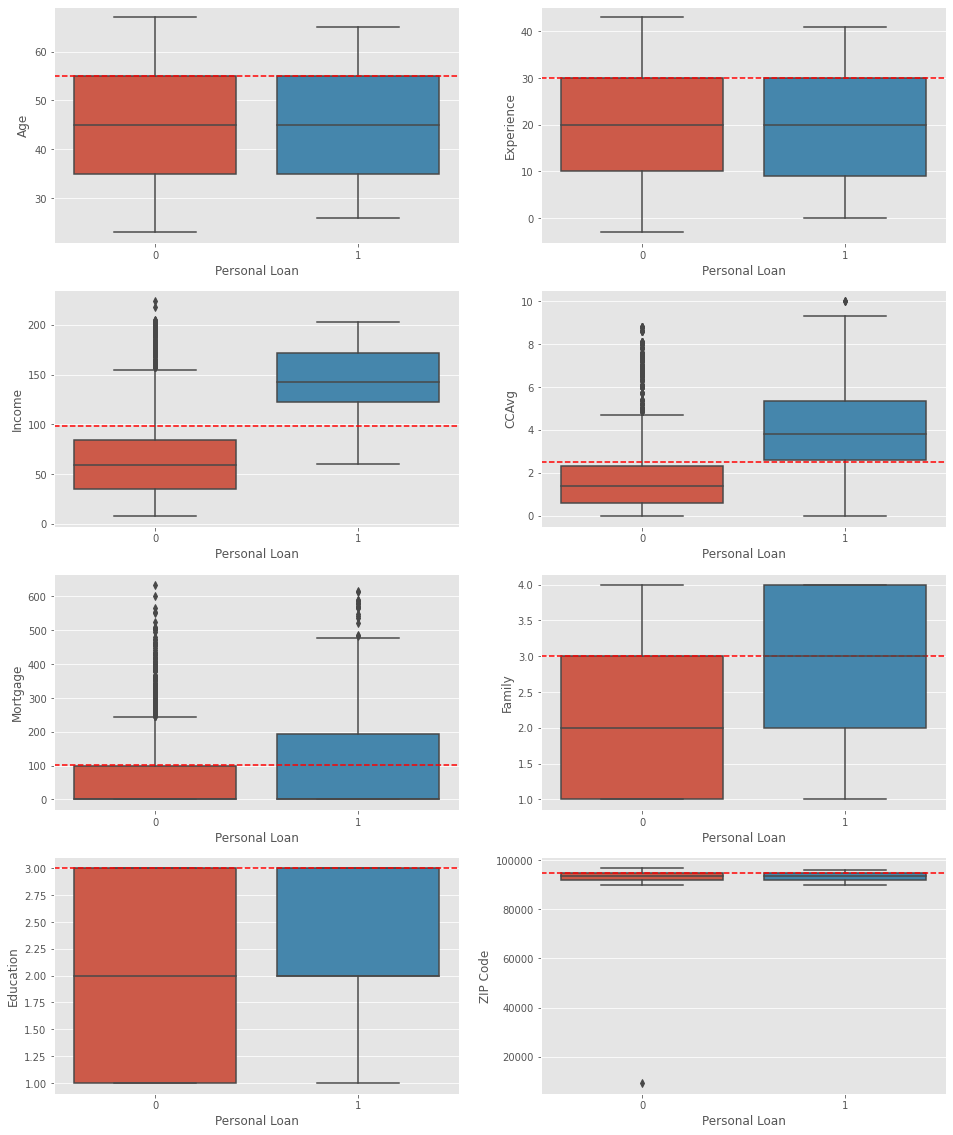

In [45]:
# feature importance
fig, ax = plt.subplots(4, 2, figsize=(16, 20))

for current_column, axis in zip(num_cols, ax.flatten()):
    sns.boxplot(x='Personal Loan', y=current_column, data=df, ax=axis)
    axis.axhline(df.describe().loc['75%', current_column], ls='--', c='red')

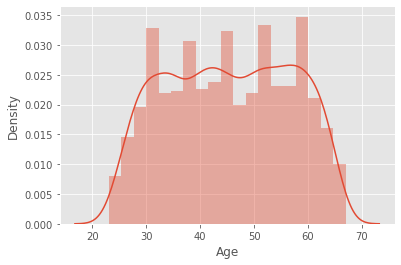

In [46]:
sns.distplot(df['Age'])
plt.show()

# Train/test split + metrics

In [47]:
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=RANDOM_STATE)
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

# Baseline

Разделим людей по их зарплате

In [48]:
means = df.groupby('Personal Loan')['Income'].mean()
means

Personal Loan
0     66.237389
1    144.745833
Name: Income, dtype: float64

In [49]:
threshold = means.mean()
def baseline_predict(df):
    return df['Income']>threshold
print('Baseline results')
bpred=baseline_predict(X_test_raw)
for score_name, score in metrics.items():
        print(score_name+': '+str(score(y_test,bpred)))

Baseline results
accuracy: 0.84
precision: 0.3495575221238938
recall: 0.8586956521739131
roc_auc: 0.84840068952308
f1: 0.49685534591194963


# Feature engineering

In [50]:
train_columns = []

class FeatureSelector(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Drops columns: ID, ZIP Code,'Age, Experience.
    '''

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        # print(X.columns)
        X = X.drop(["ID", "ZIP Code", 'Age', 'Experience'], axis=1)

        global train_columns
        train_columns = X.columns

        return X
    
    
class FeatureGemerator(TransformerMixin, BaseEstimator):
    '''
    Custom Transforemr.
    Creates several categorical columns
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # transform X via code or additional methods
        
        # is sth features
        X['IsMortgaged'] = X['Mortgage'] > 0
        X['IsFamily'] = X['Family'] > 1
        X['IsEducated'] = X['Education'] > 1

        # Is > than 75 qq
        X['IsMortgaged75'] = (X['Mortgage'] > X.describe().loc['75%', 'Mortgage']) & X['IsMortgaged']
        X['IsIncome75'] = X['Income'] > X.describe().loc['75%', 'Income']
        X['IsCCAvg75'] = X['CCAvg'] > X.describe().loc['75%', 'CCAvg']
        
        return X
    
def add_layer_to_pipeline(pipeline, layer,
                             pipeline_name='pipe', layer_name='model'):
    new_pipeline = Pipeline([
        (pipeline_name, pipeline),
        (layer_name, layer)
    ])
    
    return new_pipeline

In [51]:
# creating a pipeline to preprocess data in future
data_engeneering_pipeline = Pipeline([
    ('feature_generator', FeatureGemerator()),
    ('feature_selector', FeatureSelector()),
    ('scaler', StandardScaler())
])

# savling pipeline
joblib.dump(data_engeneering_pipeline, 'data_engeneering_pipeline.pkl')

['data_engeneering_pipeline.pkl']

## Построение модели

In [52]:
# results of preprocessing
X_train = data_engeneering_pipeline.fit_transform(X_train_raw)
X_test = data_engeneering_pipeline.fit_transform(X_test_raw)

In [53]:
# initializing models, their params and metrics
models = {'RandomForestClassifier': RandomForestClassifier(),
          'LogisticRegression': LogisticRegression(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier()
         }

params = {'LogisticRegression': {'C': np.linspace(0.01,2,15),
                                 'penalty': ['l1','l2', 'elasticnet', 'none'], 
                                 'random_state': [RANDOM_STATE]},
          'RandomForestClassifier': {'max_features': [1,3,10],
                                      'min_samples_split': [2,3,10],
                                      'min_samples_leaf': [1,3,10],
                                      'bootstrap': [False, True],
                                      'n_estimators': [50, 100, 200, 300],
                                      'n_jobs': [-1], 
                                      'random_state': [RANDOM_STATE]},
          'DecisionTreeClassifier': {'splitter': ['best', 'random'],
                                     'max_depth': ['none'] + [i for i in range(3, 9)], 
                                     'random_state': [RANDOM_STATE]},
          'KNeighborsClassifier':  {'n_neighbors': np.arange(1,50),
                                    'weights': ['uniform', 'distance']},
          'GradientBoostingClassifier': {'learning_rate': [0.001,0.01,0.1,0.05],
                                         'n_estimators': [100,500,1000],
                                         'max_depth': [3,5,10],
                                         'min_samples_split': [2,5,10], 
                                         'random_state': [RANDOM_STATE]}
}


In [54]:
def train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test, 
                                 models=models, params=params, metrics=metrics, 
                                 n_jobs=-1, verbose=1, scoring='roc_auc', n_splits=5):
    '''
    Returns a matrix (pd.DataFrame) of scores, dict of best_models \
    and dict of their best validation_scores(roc_auc)  
    '''
    
    best_scores={}
    best_estimators={}
    
    df_models = []
    df_training_scores = []
    df_scores = {metric_name:[] for metric_name, _ in metrics.items()}
    
    df = pd.DataFrame(columns=['model']) # + list(df_scores.values())) Ваня проверь, важность этого куска 
                                        # я его убрал и все заработало
    for model_name, model in models.items():
        search = GridSearchCV(model, param_grid=params[model_name], 
                              cv=StratifiedKFold(n_splits=n_splits), scoring=scoring,
                              n_jobs=n_jobs, verbose=verbose).fit(X_train, y_train)
        
        best_scores[model_name] = search.best_score_
        best_estimators[model_name] = search.best_estimator_       
        print(f'Model: {model_name},\nBest score: \
        {best_scores[model_name]}\nBest params: {best_estimators[model_name]}')            
        
        df_models.append(model_name)
        for score_name, score in metrics.items():
            # f1 and accuracy don't work with probas
            # Also RFClassifier don't have predict_proba
            try:
                preds = search.predict_proba(X_test)
                df_scores[score_name].append(score(y_test, preds))
            except Exception as e:
                preds = search.predict(X_test)
                df_scores[score_name].append(score(y_test, preds))
    df['model'] = df_models   
    for score_name, _ in df_scores.items():
        df[score_name] = df_scores[score_name]    
    return df, best_estimators, best_scores

In [55]:
%%time
scoring_df, best_params, best_scores = train_grdsearch_and_evaluate(X_train, y_train, X_test, y_test,scoring='f1')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Model: RandomForestClassifier,
Best score:         0.9366294943636164
Best params: RandomForestClassifier(bootstrap=False, max_features=10, min_samples_split=10,
                       n_jobs=-1, random_state=12)
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model: LogisticRegression,
Best score:         0.8069383602231008
Best params: LogisticRegression(C=0.2942857142857143, random_state=12)
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Model: DecisionTreeClassifier,
Best score:         0.9464271780602134
Best params: DecisionTreeClassifier(max_depth=5, random_state=12)
Fitting 5 folds for each of 98 candidates, totalling 490 fits
Model: KNeighborsClassifier,
Best score:         0.8410160146560713
Best params: KNeighborsClassifier(n_neighbors=3, weights='distance')
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Model: GradientBoostingClassifier,
Best score:         0.94016698

In [59]:
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,RandomForestClassifier,0.981,0.929412,0.858696,0.926044,0.892655
1,LogisticRegression,0.958,0.812500,0.706522,0.845001,0.755814
2,DecisionTreeClassifier,0.977,0.896552,0.847826,0.918957,0.871508
3,KNeighborsClassifier,0.965,0.870130,0.728261,0.858624,0.792899
4,GradientBoostingClassifier,0.979,0.908046,0.858696,0.924943,0.882682


In [62]:
# save scores to csv
scoring_df.to_csv('scoring_df.csv', index=None)

In [63]:
# validation results
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,RandomForestClassifier,0.981,0.929412,0.858696,0.926044,0.892655
1,LogisticRegression,0.958,0.812500,0.706522,0.845001,0.755814
2,DecisionTreeClassifier,0.977,0.896552,0.847826,0.918957,0.871508
3,KNeighborsClassifier,0.965,0.870130,0.728261,0.858624,0.792899
4,GradientBoostingClassifier,0.979,0.908046,0.858696,0.924943,0.882682


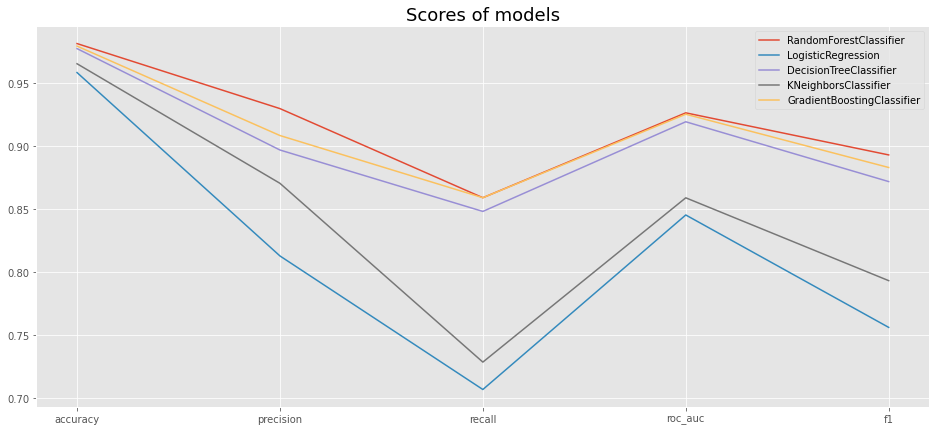

In [64]:
# validation vizualiazation
fig = plt.figure(figsize=(16, 7))
for i in range(len(scoring_df)):
    plt.plot(metrics.keys(), scoring_df.loc[i, metrics.keys()].values, label=scoring_df['model'][i])

plt.title('Scores of models', fontsize=18)
plt.legend();


In [65]:
# final model with simple interpritetion
dtc = best_params['DecisionTreeClassifier']

#saving model
joblib.dump(dtc, 'DTree_model.pkl')

# final score

prob_preds = dtc.predict_proba(X_test)[:, 1]
preds = dtc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

accuracy: 0.977
precision: 0.896551724137931
recall: 0.8478260869565217
roc_auc: 0.9873826853093277
f1: 0.8715083798882682


In [66]:
# final model with better results
rfc = best_params['RandomForestClassifier']

#saving model
joblib.dump(rfc, 'gbc_model.pkl')

# final score

prob_preds = rfc.predict_proba(X_test)[:, 1]
preds = rfc.predict(X_test)
for score_name, score in metrics.items():
    try:
        print(score_name+': '+str(score(y_test,prob_preds)))
    except:
        print(score_name+': '+str(score(y_test,preds)))

accuracy: 0.981
precision: 0.9294117647058824
recall: 0.8586956521739131
roc_auc: 0.9962351561003638
f1: 0.8926553672316385


#### Таким образом мы получили хорошее качество классификации, высокую точность и достаточно большую полноту, что должно хорошо сказаться на экономической значимости, и наша кампании принесет больше прибыли, чем предыдущая

In [67]:
# preprocessing for ddtc

# pipeline with no normalization layer
pipe_raw = data_engeneering_pipeline[:2]

# getting new X_train & X_test (Non-normalized)
X_train_raw = pipe_raw.fit_transform(X_train_raw)
X_test_raw = pipe_raw.fit_transform(X_test_raw)

# stealing params from dtc
dtc_raw = DecisionTreeClassifier()
params = dtc.get_params()
dtc_raw.set_params(**params)

# fti & evaluate
dtc_raw.fit(X_train_raw, y_train)
preds = dtc_raw.predict(X_test_raw)
f1_score(preds, y_test)

0.8729281767955801

In [68]:
# visualization
import graphviz

# DOT data
dot_data = tree.export_graphviz(dtc_raw, out_file=None, 
                                feature_names=train_columns,  
                                class_names=['1', '0'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.save('dtc_raw_tree.dot')

'dtc_raw_tree.dot'

In [69]:
!pip install pydot

In [70]:
# export to png
import pydot

(graph,) = pydot.graph_from_dot_file('dtc_raw_tree.dot')
graph.write_png('dtc_raw_tree.png')

### Оценка экономической эфффективности 

<a id='another_cell'></a>


[Another Cell](#another_cell)

сюда не смотреть, нужно для оглавления

In [71]:
conversion_rate_old = float(y_test.sum() / y_test.shape[0])
conversion_rate_new = precision_score(y_test, preds)
missing_clients = 1 - recall_score(y_test, preds)
percent_of_new_candidates = preds.sum()/y_test.shape[0]
print(f'Старый показатель конверсии на тестовой выборке равен {conversion_rate_old * 100:.1f}%')
print(f'Новый показатель конверсии на тестовой выборке равен {conversion_rate_new * 100:.1f}%')
print(f'Потеряно {missing_clients * 100:.1f}% клиентов')
print(f'Количество новых кандидатов относительно старого способа составляет {percent_of_new_candidates* 100:.1f}%')

Старый показатель конверсии на тестовой выборке равен 9.2%
Новый показатель конверсии на тестовой выборке равен 88.8%
Потеряно 14.1% клиентов
Количество новых кандидатов относительно старого способа составляет 8.9%


Пусть затраты на маркетинг на одного клиента __N__, доход с одного клиента __M__, общее количеств клиентов __n__

Profit_old = (M * 0.096 - N) * n

Profit_new = (M * 0.942  - N) * 0.086 * n 

Dif = -0.081 * M * n + 0.914 * N * n = 

Допустим на привлечение клиента мы тратим 50 рублей а потенциальный профит составляет 200 рублей, то при внедрении нашей системы мы получим 147500 рублей